# Modelos LSTM para Geração de Receitas

In [ ]:
%pip install json
%pip install tensorflow
%pip install sklearn
%pip install numpy 
%pip install tqdm
%pip install matplotlib
%pip install tqdm

## Coleta de Dados via Web Scraping

Realiza web scraping de receitas do site Panelinha.

Etapas:
1. Coleta todos os links de receitas percorrendo até 235 páginas de resultados.
2. Para cada link, extrai título, ingredientes e modo de preparo da receita.
3. Utiliza Selenium WebDriver (modo headless) para lidar com o carregamento dinâmico via JavaScript.
4. Usa BeautifulSoup para fazer o parsing do HTML.
5. Gera o arquivo corpus.txt no formato JSONL (um JSON por linha) com todas as receitas coletadas.

In [ ]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from urllib.parse import urljoin
from selenium import webdriver
from bs4 import BeautifulSoup
import json
import time
import re

# Configurações base do site
BASE_URL = "https://panelinha.com.br"
SEARCH_URL = "https://panelinha.com.br/busca?query=&page={}&menu%5Bpage_type%5D=Receitas"

def init_driver():
    """Inicializa o driver do Selenium com configurações headless"""
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def get_recipe_links(driver):
    """Coleta links de receitas de todas as páginas de busca"""
    links = []
    page = 1
    while page <= 235:
        url = SEARCH_URL.format(page)
        print(f"Acessando página {page}: {url}")
        driver.get(url)
        time.sleep(3)  # Aguarda carregamento do JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")
        container = soup.select_one(".hitsContainer2C .ais-Hits ol")
        if not container:
            print(f"Nenhum resultado encontrado na página {page}, encerrando coleta.")
            break

        for a in container.select("li a[href]"):
            recipe_url = urljoin(BASE_URL, a["href"])
            # Filtra apenas URLs válidas de receitas
            if re.match(r"^https://panelinha\.com\.br/receita/.+", recipe_url):
                if recipe_url not in links:
                    links.append(recipe_url)

        page += 1

    return links

def scrape_recipe(driver, url):
    """Extrai dados de uma receita individual"""
    print(f"Coletando receita: {url}")
    driver.get(url)
    time.sleep(2)  # Aguarda carregamento da página

    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extrai título da receita
    titulo = soup.find("h1").get_text(strip=True).lower() if soup.find("h1") else ""

    # Extrai lista de ingredientes
    ingredientes = []
    h5_ing = soup.find("h5", string=lambda x: x and "Ingredientes" in x)
    if h5_ing:
        ul = h5_ing.find_next_sibling("ul")
        if ul:
            ingredientes = [li.get_text(strip=True).lower() for li in ul.find_all("li")]

    # Extrai modo de preparo
    preparo = []
    h5_prep = soup.find("h5", string=lambda x: x and "Modo de preparo" in x)
    if h5_prep:
        ol = h5_prep.find_next_sibling("ol")
        if ol:
            preparo = [li.get_text(strip=True).lower() for li in ol.find_all("li")]

    return {
        "url": url.lower(),
        "titulo": titulo,
        "ingredientes": ingredientes,
        "preparo": preparo
    }

if __name__ == "__main__":
    driver = init_driver()

    try:
        # Coleta links de todas as receitas
        receitas_links = get_recipe_links(driver)
        print("Total de receitas encontradas:", len(receitas_links))

        # Extrai dados de cada receita
        corpus = []
        for link in receitas_links:
            dados = scrape_recipe(driver, link)
            if dados:
                corpus.append(dados)

        # Salva corpus em arquivo JSONL
        with open("corpus.txt", "w", encoding="utf-8") as f:
            for item in corpus:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")

        print("Corpus salvo em corpus.txt")
    finally:
        driver.quit()

## Pré-processamento e Tokenização do Corpus

Pré-processa o corpus de receitas coletado via web scraping.

Etapas:
1. Carrega e organiza os dados textuais, unindo título, ingredientes e modo de preparo.
2. Aplica tokenização com o Tokenizer do Keras, incluindo tratamento para palavras fora do vocabulário (OOV).
3. Divide o corpus em treino (80%), validação (10%) e teste (10%) de forma estratificada.
4. Define uma semente aleatória para garantir reprodutibilidade.
5. Salva os objetos processados para uso nas próximas etapas do projeto.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import json
import os

CORPUS_FILE = "corpus.txt"

# Verificação de integridade do arquivo de corpus
if not os.path.exists(CORPUS_FILE):
    print(f"Erro: O arquivo '{CORPUS_FILE}' não foi encontrado no diretório.")
    print("Certifique-se de que o arquivo de corpus está disponível antes de executar o processamento.")
else:
    print(f"Arquivo '{CORPUS_FILE}' localizado. Iniciando pré-processamento...")
    
    # Configurações de processamento
    OOV_TOKEN = "<OOV>"
    TEST_SIZE = 0.2
    VAL_SIZE = 0.5  # 50% dos dados de teste alocados para validação
    NUM_WORDS = None  # Utilizar vocabulário completo

    # Carregamento e estruturação dos textos
    corpus_texts = []
    with open(CORPUS_FILE, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            # Combina título, ingredientes e modo de preparo em documento único
            texto = " ".join([data["titulo"]] + data["ingredientes"] + data["preparo"])
            corpus_texts.append(texto)

    print(f"Total de receitas carregadas do corpus: {len(corpus_texts)}")

    # Tokenização do vocabulário
    tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(corpus_texts)

    # Conversão para representação sequencial numérica
    sequences = tokenizer.texts_to_sequences(corpus_texts)

    word_index = tokenizer.word_index
    print(f"Tamanho do vocabulário identificado: {len(word_index)}")

    # Divisão em conjuntos de treino, validação e teste
    train_seq, temp_seq = train_test_split(sequences, test_size=TEST_SIZE, random_state=42)
    val_seq, test_seq = train_test_split(temp_seq, test_size=VAL_SIZE, random_state=42)

    print("-" * 30)
    print(f"Dados de Treino:   {len(train_seq)} receitas")
    print(f"Dados de Validação: {len(val_seq)} receitas")
    print(f"Dados de Teste:     {len(test_seq)} receitas")
    print("-" * 30)

    # Persistência dos objetos processados
    with open("tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)

    np.save("train_seq.npy", np.array(train_seq, dtype=object))
    np.save("val_seq.npy", np.array(val_seq, dtype=object))
    np.save("test_seq.npy", np.array(test_seq, dtype=object))

    print("Pré-processamento concluído com sucesso")
    print("Arquivos gerados: tokenizer.pkl, train_seq.npy, val_seq.npy, test_seq.npy")

Arquivo 'C:\Users\Gustavo\Documents\nlp-pt-lstm-gen\src\corpus\corpus.txt' encontrado. Iniciando o pré-processamento...
Total de receitas carregadas do corpus: 2787
Tamanho do vocabulário encontrado: 4055
------------------------------
Dados de Treino:   2229 receitas
Dados de Validação: 279 receitas
Dados de Teste:     279 receitas
------------------------------
✅ Pré-processamento concluído com sucesso!
Arquivos salvos: tokenizer.pkl, train_seq.npy, val_seq.npy, test_seq.npy


## Implementação e Treinamento do Modelo LSTM Baseline

Implementa e treina o modelo LSTM baseline para geração de texto em português.

Etapas:
1. Prepara os dados sequenciais com padding e one-hot encoding.
2. Define a arquitetura do modelo com camadas de Embedding, LSTM e Densa.
3. Implementa a métrica personalizada de perplexidade.
4. Treina o modelo utilizando callbacks para salvar o melhor resultado e aplicar parada antecipada.
5. Avalia o modelo de forma quantitativa (perplexidade) e qualitativa (geração de texto com diferentes temperaturas).
6. Gera gráficos de evolução das métricas e salva todos os artefatos para análise posterior.

Dados carregados com sucesso!
Tamanho do vocabulário: 4056
Tamanho máximo da sequência: 271
Shape de X_train_pad: (172931, 271)
Shape de y_train_cat: (172931, 4056)


c:\Users\Gustavo\Documents\nlp-pt-lstm-gen\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1542 - loss: 5.3413 - perplexity: 411.1152

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1404s 1s/step - accuracy: 0.2171 - loss: 4.6281 - perplexity: 162.4668 - val_accuracy: 0.3353 - val_loss: 3.6052 - val_perplexity: 42.5427
Epoch 2/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3505 - loss: 3.4732 - perplexity: 33.5408

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1431s 1s/step - accuracy: 0.3724 - loss: 3.3158 - perplexity: 28.8023 - val_accuracy: 0.4168 - val_loss: 2.9864 - val_perplexity: 23.2592
Epoch 3/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4231 - loss: 2.9061 - perplexity: 18.7765

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1438s 1s/step - accuracy: 0.4309 - loss: 2.8363 - perplexity: 17.5244 - val_accuracy: 0.4531 - val_loss: 2.7013 - val_perplexity: 17.5570
Epoch 4/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4559 - loss: 2.6001 - perplexity: 13.7554

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1408s 1s/step - accuracy: 0.4627 - loss: 2.5617 - perplexity: 13.2352 - val_accuracy: 0.4775 - val_loss: 2.5347 - val_perplexity: 14.8429
Epoch 5/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4823 - loss: 2.3994 - perplexity: 11.2202

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1422s 1s/step - accuracy: 0.4859 - loss: 2.3785 - perplexity: 11.0018 - val_accuracy: 0.4907 - val_loss: 2.4371 - val_perplexity: 13.5167
Epoch 6/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4991 - loss: 2.2564 - perplexity: 9.7322

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1483s 1s/step - accuracy: 0.5018 - loss: 2.2429 - perplexity: 9.6046 - val_accuracy: 0.5013 - val_loss: 2.3717 - val_perplexity: 12.6630
Epoch 7/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5135 - loss: 2.1435 - perplexity: 8.6831

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1520s 1s/step - accuracy: 0.5138 - loss: 2.1418 - perplexity: 8.6739 - val_accuracy: 0.5106 - val_loss: 2.3312 - val_perplexity: 12.0884
Epoch 8/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5217 - loss: 2.0564 - perplexity: 7.9491

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1560s 1s/step - accuracy: 0.5237 - loss: 2.0561 - perplexity: 7.9915 - val_accuracy: 0.5188 - val_loss: 2.2992 - val_perplexity: 11.6911
Epoch 9/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5350 - loss: 1.9782 - perplexity: 7.3574

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1594s 1s/step - accuracy: 0.5352 - loss: 1.9864 - perplexity: 7.4228 - val_accuracy: 0.5238 - val_loss: 2.2778 - val_perplexity: 11.3444
Epoch 10/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5403 - loss: 1.9239 - perplexity: 6.9524

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1616s 1s/step - accuracy: 0.5418 - loss: 1.9265 - perplexity: 6.9715 - val_accuracy: 0.5273 - val_loss: 2.2642 - val_perplexity: 11.1704
Epoch 11/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5509 - loss: 1.8653 - perplexity: 6.5553

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1613s 1s/step - accuracy: 0.5489 - loss: 1.8747 - perplexity: 6.6191 - val_accuracy: 0.5312 - val_loss: 2.2487 - val_perplexity: 10.9346
Epoch 12/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5602 - loss: 1.8139 - perplexity: 6.2282

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1611s 1s/step - accuracy: 0.5574 - loss: 1.8262 - perplexity: 6.3209 - val_accuracy: 0.5325 - val_loss: 2.2443 - val_perplexity: 10.8885
Epoch 13/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5659 - loss: 1.7705 - perplexity: 5.9610

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1606s 1s/step - accuracy: 0.5627 - loss: 1.7864 - perplexity: 6.0549 - val_accuracy: 0.5370 - val_loss: 2.2369 - val_perplexity: 10.7576
Epoch 14/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5698 - loss: 1.7346 - perplexity: 5.7475

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1615s 1s/step - accuracy: 0.5677 - loss: 1.7493 - perplexity: 5.8352 - val_accuracy: 0.5358 - val_loss: 2.2305 - val_perplexity: 10.5890
Epoch 15/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5737 - loss: 1.7085 - perplexity: 5.5968

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1627s 1s/step - accuracy: 0.5738 - loss: 1.7154 - perplexity: 5.6361 - val_accuracy: 0.5412 - val_loss: 2.2271 - val_perplexity: 10.5592
Epoch 16/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5809 - loss: 1.6697 - perplexity: 5.3858

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1647s 1s/step - accuracy: 0.5778 - loss: 1.6833 - perplexity: 5.4641 - val_accuracy: 0.5405 - val_loss: 2.2266 - val_perplexity: 10.5114
Epoch 17/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5883 - loss: 1.6329 - perplexity: 5.1838

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1679s 1s/step - accuracy: 0.5831 - loss: 1.6546 - perplexity: 5.3068 - val_accuracy: 0.5433 - val_loss: 2.2227 - val_perplexity: 10.4754
Epoch 18/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1663s 1s/step - accuracy: 0.5877 - loss: 1.6275 - perplexity: 5.1642 - val_accuracy: 0.5458 - val_loss: 2.2244 - val_perplexity: 10.4799
Epoch 19/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5953 - loss: 1.5922 - perplexity: 4.9799

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1698s 1s/step - accuracy: 0.5912 - loss: 1.6052 - perplexity: 5.0446 - val_accuracy: 0.5493 - val_loss: 2.2219 - val_perplexity: 10.4711
Epoch 20/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5985 - loss: 1.5663 - perplexity: 4.8484

1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1690s 1s/step - accuracy: 0.5962 - loss: 1.5816 - perplexity: 4.9409 - val_accuracy: 0.5475 - val_loss: 2.2195 - val_perplexity: 10.3862
Treinamento concluído!
Perplexidade no TREINO: 4.09
Perplexidade na VALIDAÇÃO: 8.43

TEXTO SEMENTE: 'o primeiro passo é cortar a cebola'

--- GERANDO TEXTO COM TEMPERATURA 0.7 ---
o primeiro passo é cortar a cebola 1 maço de couve 1 cebola 1 dente de alho ½ xícara chá de água 1 colher sopa de caldo de limão sal e pimenta do reino moída na hora a gosto lave seque e corte a cebola em meias
------------------------------------------------

--- GERANDO TEXTO COM TEMPERATURA 1.0 ---
o primeiro passo é cortar a cebola 2 batatas 2 mandioquinhas batatas baroas cerca de 500 g 2 dentes de alho 1 xícara chá de damasco seco em conserva ¼ de xícara chá de vinho branco 1 cebola 1 cenoura ½ xícara chá de cogumelo ⅓ de
------------------------------------------------

--- GERANDO TEXTO COM TEMPERATURA 1.3 ---
o primeiro passo é cortar a

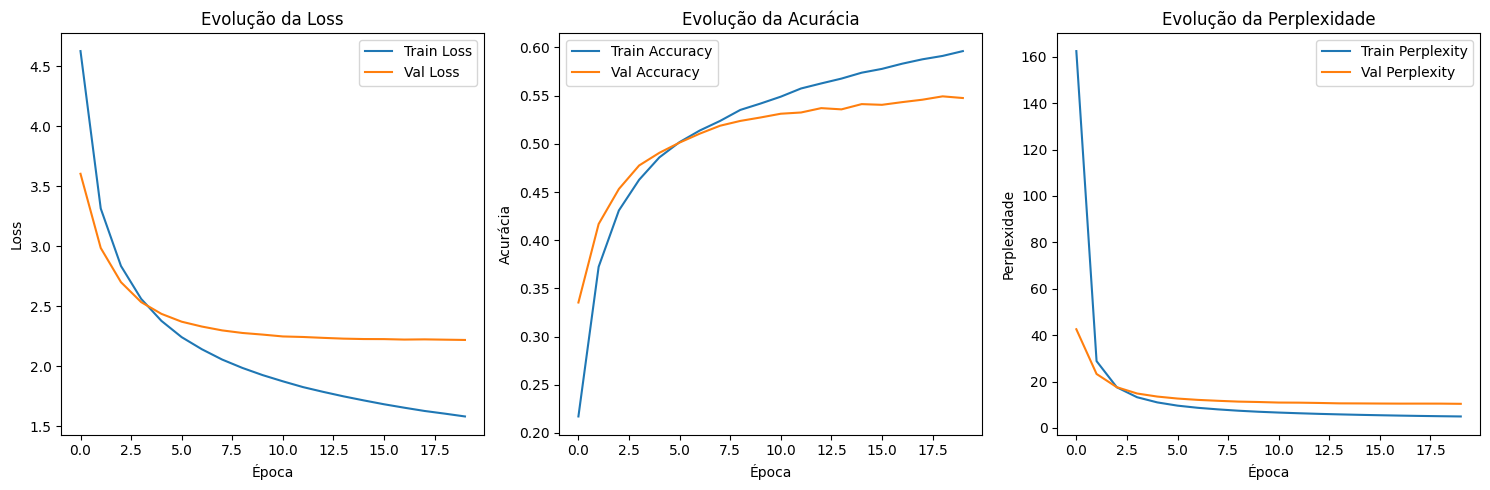


💾 Salvando modelo e métricas finais...


TypeError: Object of type float32 is not JSON serializable

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import json
import os

# Verificação de pré-requisitos
required_files = ["tokenizer.pkl", "train_seq.npy", "val_seq.npy"]
files_exist = all(os.path.exists(f) for f in required_files)

if not files_exist:
    print("Arquivos de pré-processamento não encontrados.")
    print("Execute primeiro o código de pré-processamento.")
else:
    # Carregamento dos dados pré-processados
    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)

    train_seq = np.load("train_seq.npy", allow_pickle=True)
    val_seq = np.load("val_seq.npy", allow_pickle=True)

    print("Dados carregados com sucesso")

    # Preparação dos dados para o modelo
    vocab_size = len(tokenizer.word_index) + 1

    def create_sequences(sequences):
        """Cria sequências de entrada e saída para treinamento do modelo"""
        X, y = [], []
        for seq in sequences:
            for i in range(1, len(seq)):
                n_gram_sequence = seq[:i+1]
                X.append(n_gram_sequence[:-1])
                y.append(n_gram_sequence[-1])
        return X, y

    X_train, y_train = create_sequences(train_seq)
    X_val, y_val = create_sequences(val_seq)

    # Aplicação de padding para sequências de tamanho fixo
    max_sequence_len = max([len(x) for x in X_train])
    X_train_pad = pad_sequences(X_train, maxlen=max_sequence_len, padding='pre')
    X_val_pad = pad_sequences(X_val, maxlen=max_sequence_len, padding='pre')

    # Codificação one-hot dos rótulos
    y_train_cat = to_categorical(y_train, num_classes=vocab_size)
    y_val_cat = to_categorical(y_val, num_classes=vocab_size)

    print(f"Tamanho do vocabulário: {vocab_size}")
    print(f"Tamanho máximo da sequência: {max_sequence_len}")
    print(f"Shape de X_train_pad: {X_train_pad.shape}")
    print(f"Shape de y_train_cat: {y_train_cat.shape}")

    # Definição das métricas customizadas
    def perplexity(y_true, y_pred):
        """Calcula a perplexidade como média exponencial da entropia cruzada"""
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return tf.exp(tf.reduce_mean(cross_entropy))

    def calculate_dataset_perplexity(model, X_pad, y_cat, batch_size=128):
        """Calcula perplexidade em conjunto de dados completo"""
        predictions = model.predict(X_pad, batch_size=batch_size, verbose=0)
        predictions = np.clip(predictions, 1e-7, 1.0)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_cat, predictions)
        return np.exp(np.mean(cross_entropy.numpy()))

    # Configuração de hiperparâmetros
    EMBEDDING_DIM = 100
    LSTM_UNITS = 150
    EPOCHS = 20
    BATCH_SIZE = 128

    # Definição da arquitetura do modelo
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_sequence_len),
        LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
        Dense(vocab_size, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy', perplexity]
    )

    model.summary()

    # Configuração de callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "best_baseline_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    )

    # Execução do treinamento
    history = model.fit(
        X_train_pad, y_train_cat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val_cat),
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    print("Treinamento concluído")

    # Avaliação quantitativa do modelo
    train_perplexity = calculate_dataset_perplexity(model, X_train_pad, y_train_cat)
    val_perplexity = calculate_dataset_perplexity(model, X_val_pad, y_val_cat)
    
    print(f"Perplexidade no Treino: {train_perplexity:.2f}")
    print(f"Perplexidade na Validação: {val_perplexity:.2f}")

    # Função para geração de texto
    def safe_generate_text(seed_text, num_words_to_generate, model, tokenizer, max_sequence_len, temperature=1.0):
        """Gera texto sequencial com controle de temperatura e tratamento de erros"""
        generated_text = seed_text.lower()
        
        for _ in range(num_words_to_generate):
            token_list = tokenizer.texts_to_sequences([generated_text])[0]
            
            if len(token_list) == 0:
                break
                
            padded_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
            
            try:
                preds = model.predict(padded_list, verbose=0)[0]
                preds = np.clip(preds, 1e-7, 1.0)
                
                if temperature > 0:
                    preds = np.log(preds) / temperature
                    exp_preds = np.exp(preds)
                    preds = exp_preds / np.sum(exp_preds)
                
                predicted_index = np.random.choice(len(preds), p=preds)
                output_word = tokenizer.index_word.get(predicted_index, "")
                
                if not output_word or output_word == "<OOV>":
                    break
                    
                generated_text += " " + output_word
                
            except Exception as e:
                print(f"Erro na geração: {e}")
                break
                
        return generated_text

    # Geração de amostras de texto
    seed_text = "o primeiro passo é cortar a cebola"

    print("\n" + "="*60)
    print(f"Texto Semente: '{seed_text}'")
    print("="*60)

    for temp in [0.7, 1.0, 1.3]:
        print(f"\n--- Gerando Texto com Temperatura {temp} ---")
        generated_recipe = safe_generate_text(
            seed_text, 40, model, tokenizer, max_sequence_len, temperature=temp
        )
        print(generated_recipe)
        print("-" * 50)

    # Visualização das métricas de treinamento
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Evolução da Função de Perda')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Evolução da Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['perplexity'], label='Perplexidade Treino')
    plt.plot(history.history['val_perplexity'], label='Perplexidade Validação')
    plt.title('Evolução da Perplexidade')
    plt.xlabel('Época')
    plt.ylabel('Perplexidade')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Persistência dos resultados
    model.save("baseline_lstm_model.h5")
    
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    
    final_metrics = {
        'final_train_perplexity': float(train_perplexity),
        'final_val_perplexity': float(val_perplexity),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'vocab_size': vocab_size,
        'max_sequence_len': max_sequence_len
    }
    
    with open("baseline_metrics.json", "w") as f:
        json.dump(final_metrics, f, indent=2)
    
    print("Modelo baseline finalizado e artefatos salvos")
    print(f"Métricas finais - Treino: {train_perplexity:.2f}, Validação: {val_perplexity:.2f}")

## Implementação da Variante com Embeddings FastText Pré-treinados

Implementa a variante do modelo LSTM com embeddings FastText pré-treinados em português.

Etapas:
1. Realiza o download automático dos vetores de embeddings FastText.
2. Cria uma matriz de embedding compatível com o vocabulário do corpus.
3. Adota um treinamento em duas fases:
   - Fase 1: embeddings congelados para aproveitar o conhecimento linguístico prévio.
   - Fase 2: fine-tuning com embeddings ajustáveis ao domínio de receitas.
4. Compara o desempenho entre embeddings pré-treinados e embeddings treinados do zero na geração de texto.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import requests
import shutil
import pickle
import gzip
import json
import os

def download_fasttext_ptbr():
    """
    Realiza download dos embeddings FastText em português
    Retorna o caminho para o arquivo extraído
    """
    fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz"
    local_path = "cc.pt.300.vec.gz"
    extracted_path = "cc.pt.300.vec"
    
    if not os.path.exists(extracted_path):
        # Download do arquivo com barra de progresso
        response = requests.get(fasttext_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(local_path, 'wb') as f, tqdm(
            desc="Download FastText",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
        
        # Extração do arquivo compactado
        with gzip.open(local_path, 'rb') as f_in:
            with open(extracted_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Limpeza do arquivo temporário
        os.remove(local_path)
        print("Download e extração do FastText concluídos")
    
    return extracted_path

def load_fasttext_embeddings(embedding_path, word_index, embedding_dim=300):
    """
    Carrega embeddings FastText e constrói matriz para o vocabulário específico
    Retorna matriz de embedding e taxa de cobertura
    """
    embeddings_index = {}
    
    # Leitura do arquivo de embeddings
    with open(embedding_path, 'r', encoding='utf-8') as f:
        next(f)  # Ignora linha de cabeçalho
        for line in tqdm(f, desc="Carregando embeddings"): 
            values = line.split()
            if len(values) < embedding_dim + 1:
                continue
            word = values[0]
            coefs = np.asarray(values[1:embedding_dim+1], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f"Embeddings carregados: {len(embeddings_index)} palavras")
    
    # Construção da matriz de embedding
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    words_found = 0
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1
        else:
            # Inicialização aleatória para palavras não encontradas
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    coverage = words_found / len(word_index) * 100
    print(f"Cobertura do vocabulário: {words_found}/{len(word_index)} ({coverage:.2f}%)")
    
    return embedding_matrix, coverage

# Carregamento dos dados pré-processados
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

train_seq = np.load("train_seq.npy", allow_pickle=True)
val_seq = np.load("val_seq.npy", allow_pickle=True)
test_seq = np.load("test_seq.npy", allow_pickle=True)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f"Dados carregados: Vocabulário={vocab_size}")

# Preparação das sequências de treinamento
def create_sequences(sequences):
    """Converte sequências em pares input-output para treinamento"""
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            n_gram_sequence = seq[:i+1]
            X.append(n_gram_sequence[:-1])
            y.append(n_gram_sequence[-1])
    return X, y

X_train, y_train = create_sequences(train_seq)
X_val, y_val = create_sequences(val_seq)

max_sequence_len = max([len(x) for x in X_train])
X_train_pad = pad_sequences(X_train, maxlen=max_sequence_len, padding='pre')
X_val_pad = pad_sequences(X_val, maxlen=max_sequence_len, padding='pre')

y_train_cat = to_categorical(y_train, num_classes=vocab_size)
y_val_cat = to_categorical(y_val, num_classes=vocab_size)

print(f"Dados preparados: X_train {X_train_pad.shape}, X_val {X_val_pad.shape}")

# Download e carregamento dos embeddings FastText
embedding_path = download_fasttext_ptbr()
embedding_matrix, coverage = load_fasttext_embeddings(embedding_path, word_index)

# Definição da métrica de perplexidade
def perplexity(y_true, y_pred):
    """Calcula perplexidade como métrica de avaliação"""
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.exp(tf.reduce_mean(cross_entropy))

# Configuração de hiperparâmetros
EMBEDDING_DIM = 300  # Dimensão dos embeddings FastText
LSTM_UNITS = 150
EPOCHS_PRETRAIN = 10   # Fase com embeddings congelados
EPOCHS_FINETUNE = 10   # Fase de fine-tuning
BATCH_SIZE = 128

# Construção do modelo com embeddings pré-treinados
fasttext_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=max_sequence_len,
        weights=[embedding_matrix],
        trainable=False  # Embeddings inicialmente congelados
    ),
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
    Dense(vocab_size, activation='softmax')
])

fasttext_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', perplexity]
)

print("Modelo FastText criado - embeddings inicialmente congelados")
fasttext_model.summary()

# Fase 1: Treinamento com embeddings congelados
print("FASE 1: Treinamento com embeddings congelados")
history_phase1 = fasttext_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_PRETRAIN,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Fase 2: Fine-tuning dos embeddings
print("FASE 2: Fine-tuning - embeddings liberados para ajuste")

# Liberação da camada de embedding para treinamento
fasttext_model.layers[0].trainable = True

# Recompilação com taxa de aprendizado reduzida
fasttext_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', perplexity]
)

history_phase2 = fasttext_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_FINETUNE,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Consolidação dos históricos de treinamento
full_history = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'perplexity': history_phase1.history['perplexity'] + history_phase2.history['perplexity'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'val_perplexity': history_phase1.history['val_perplexity'] + history_phase2.history['val_perplexity']
}

# Avaliação da variante FastText
def calculate_dataset_perplexity(model, X_pad, y_cat, batch_size=128):
    """Calcula perplexidade em conjunto de dados completo"""
    predictions = model.predict(X_pad, batch_size=batch_size, verbose=0)
    predictions = np.clip(predictions, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_cat, predictions)
    return np.exp(np.mean(cross_entropy.numpy()))

fasttext_train_ppl = calculate_dataset_perplexity(fasttext_model, X_train_pad, y_train_cat)
fasttext_val_ppl = calculate_dataset_perplexity(fasttext_model, X_val_pad, y_val_cat)

print("Métricas da variante FastText:")
print(f"   Perplexidade Treino: {fasttext_train_ppl:.2f}")
print(f"   Perplexidade Validação: {fasttext_val_ppl:.2f}")
print(f"   Cobertura FastText: {coverage:.2f}%")

# Persistência do modelo e métricas
fasttext_model.save("fasttext_variant_model.h5")

variant_metrics = {
    'fasttext_train_perplexity': float(fasttext_train_ppl),
    'fasttext_val_perplexity': float(fasttext_val_ppl),
    'fasttext_coverage': float(coverage),
    'final_val_accuracy': float(full_history['val_accuracy'][-1]),
    'embedding_dim': EMBEDDING_DIM,
    'training_phases': f"{EPOCHS_PRETRAIN}+{EPOCHS_FINETUNE} épocas"
}

with open("fasttext_variant_metrics.json", "w") as f:
    json.dump(variant_metrics, f, indent=2)

with open("fasttext_training_history.pkl", "wb") as f:
    pickle.dump(full_history, f)

print("Variante FastText salva com sucesso")

Dados carregados: Vocabulário=4056
Dados preparados: X_train (172931, 271), X_val (21846, 271)


Download: 100%|██████████| 1.18G/1.18G [00:58<00:00, 21.7MB/s] 


Download e extração do FastText concluídos.


Lendo embeddings: 2000000it [01:47, 18586.20it/s]
c:\Users\Gustavo\Documents\nlp-pt-lstm-gen\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Embeddings carregados: 2000000 palavras
Cobertura do vocabulário: 3759/4055 (92.70%)
Modelo FastText criado (embeddings congelados)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,216,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,216,800 (4.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,216,800 (4.64 MB)

FASE 1: Treinamento com embeddings CONGELADOS
Epoch 1/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2150s 2s/step - accuracy: 0.2203 - loss: 4.5981 - perplexity: 155.9881 - val_accuracy: 0.3273 - val_loss: 3.6359 - val_perplexity: 43.3531
Epoch 2/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2084s 2s/step - accuracy: 0.3478 - loss: 3.4094 - perplexity: 31.4688 - val_accuracy: 0.3957 - val_loss: 3.0690 - val_perplexity: 24.9796
Epoch 3/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2109s 2s/step - accuracy: 0.3974 - loss: 2.9726 - perplexity: 20.0541 - val_accuracy: 0.4320 - val_loss: 2.7789 - val_perplexity: 18.8297
Epoch 4/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2113s 2s/step - accuracy: 0.4280 - loss: 2.7185 - perplexity: 15.5250 - val_accuracy: 0.4536 - val_loss: 2.6138 - val_perplexity: 15.9466
Epoch 5/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2118s 2s/step - accuracy: 0.4511 - loss: 2.5453 - perplexity: 13.0222 - val_accuracy: 0.4720 - val_loss: 2.5092 - val_perplexity: 14.3831
Epoch 6/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2114s 2s/st

Métricas da variante FastText:
   Perplexidade TREINO: 5.27
   Perplexidade VALIDAÇÃO: 8.06
   Cobertura FastText: 92.70%
Variante FastText salva!


## Análise Comparativa Sistemática: Baseline vs FastText

Compara o modelo LSTM baseline com a variante usando embeddings FastText pré-treinados.

Etapas:
1. Gera visualizações comparativas das métricas de treinamento (perplexidade, acurácia e loss).
2. Realiza comparação estatística dos resultados finais entre os modelos.
3. Avalia qualitativamente os modelos por meio da geração de texto com diferentes temperaturas.
4. Analisa o impacto dos embeddings pré-treinados no desempenho da geração de texto em português, considerando aspectos quantitativos e qualitativos.

Comparação Sistemática: Modelo Baseline vs Variante FastText
Modelos e métricas carregados com sucesso


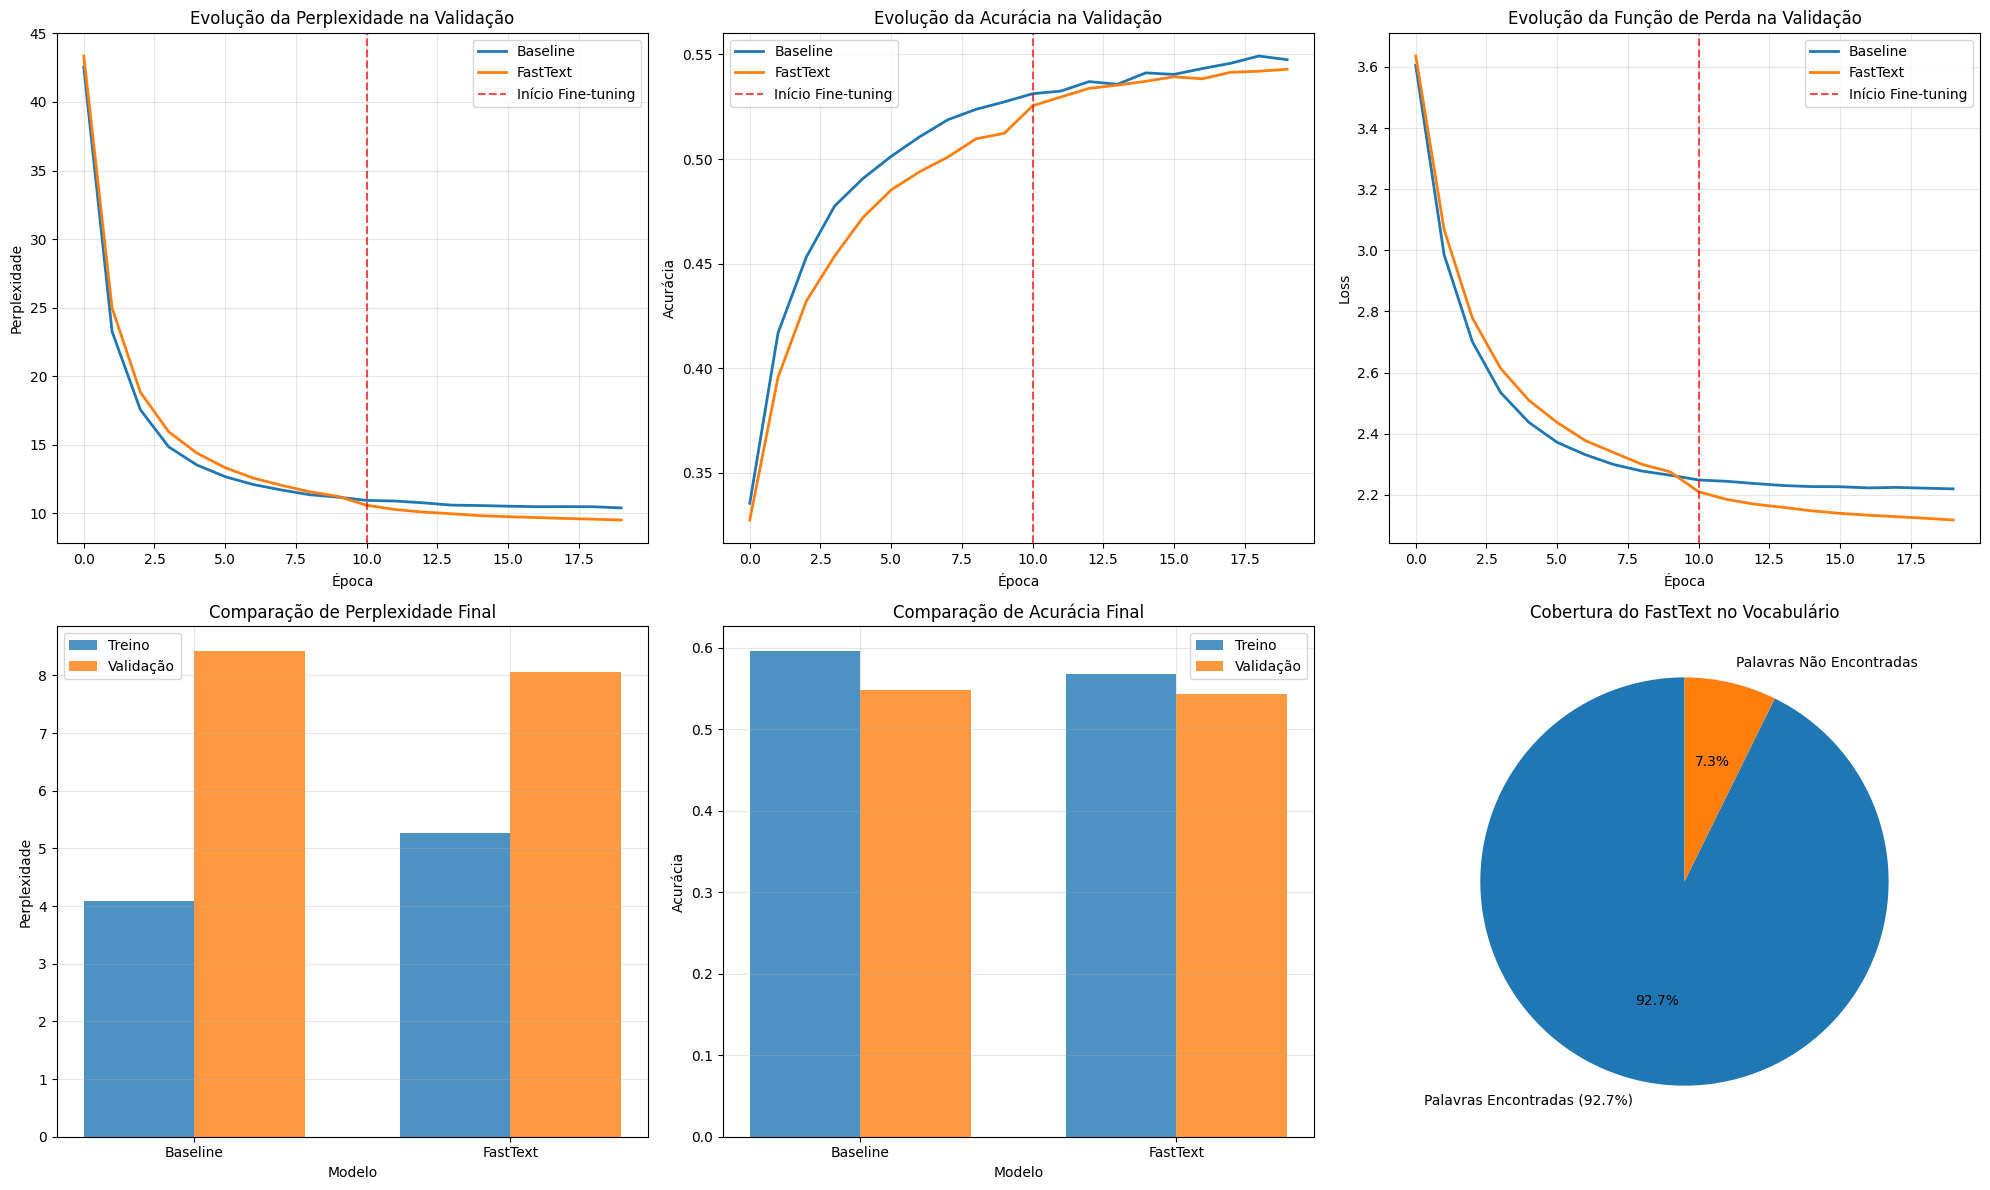

RESUMO COMPARATIVO DOS MODELOS
BASELINE (Embeddings Treinados do Zero):
  • Perplexidade Treino: 4.09
  • Perplexidade Validação: 8.43
  • Acurácia Final: 0.548

FASTTEXT (Embeddings Pré-treinados + Fine-tuning):
  • Perplexidade Treino: 5.27
  • Perplexidade Validação: 8.06
  • Acurácia Final: 0.543
  • Cobertura do Vocabulário: 92.70%

ANÁLISE DE MELHORIAS:
  • Redução na Perplexidade de Validação: +4.39%
  • Redução no Overfitting: 1.55 pontos

COMPARAÇÃO DE TEXTO GERADO - TEMPERATURA 0.7

SEED 1: 'o primeiro passo é cortar a cebola'
--------------------------------------------------
BASELINE:  o primeiro passo é cortar a cebola 300 g de macarrão espaguete ou outra massa longa de grano duro 1 cebola 1 dente de alho ⅓ de xícara chá de azeite ½ colher chá de pimenta síria ½ xícara chá de vinagre de vinho branco azeite andorinha
FASTTEXT:  o primeiro passo é cortar a cebola caramelizada 2 bifes de frango com pele e osso cerca de 1 kg 1 xícara chá de queijo meia cura ralado grosso ½ ceb

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

print("Comparação Sistemática: Modelo Baseline vs Variante FastText")

# Definição da função de perplexidade para carregamento dos modelos
def perplexity(y_true, y_pred):
    """Métrica de perplexidade para avaliação dos modelos"""
    import tensorflow as tf
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.exp(tf.reduce_mean(cross_entropy))

# Carregamento dos modelos treinados e métricas
baseline_model = load_model("baseline_lstm_model.h5", custom_objects={'perplexity': perplexity})
fasttext_model = load_model("fasttext_variant_model.h5", custom_objects={'perplexity': perplexity})

with open("baseline_metrics.json", "r") as f:
    baseline_metrics = json.load(f)

with open("fasttext_variant_metrics.json", "r") as f:
    fasttext_metrics = json.load(f)

# Carregamento dos históricos de treinamento
with open("training_history.pkl", "rb") as f:
    baseline_history = pickle.load(f)

with open("fasttext_training_history.pkl", "rb") as f:
    fasttext_history = pickle.load(f)

print("Modelos e métricas carregados com sucesso")

# Visualização comparativa das métricas de treinamento
plt.figure(figsize=(20, 12))

# Evolução da perplexidade na validação
plt.subplot(2, 3, 1)
plt.plot(baseline_history['val_perplexity'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_perplexity'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Início Fine-tuning')
plt.title('Evolução da Perplexidade na Validação')
plt.xlabel('Época')
plt.ylabel('Perplexidade')
plt.legend()
plt.grid(True, alpha=0.3)

# Evolução da acurácia na validação
plt.subplot(2, 3, 2)
plt.plot(baseline_history['val_accuracy'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_accuracy'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Início Fine-tuning')
plt.title('Evolução da Acurácia na Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# Evolução da função de perda na validação
plt.subplot(2, 3, 3)
plt.plot(baseline_history['val_loss'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_loss'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Início Fine-tuning')
plt.title('Evolução da Função de Perda na Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Comparação de perplexidade final
plt.subplot(2, 3, 4)
models = ['Baseline', 'FastText']
ppl_train = [baseline_metrics['final_train_perplexity'], fasttext_metrics['fasttext_train_perplexity']]
ppl_val = [baseline_metrics['final_val_perplexity'], fasttext_metrics['fasttext_val_perplexity']]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, ppl_train, width, label='Treino', alpha=0.8)
plt.bar(x + width/2, ppl_val, width, label='Validação', alpha=0.8)
plt.title('Comparação de Perplexidade Final')
plt.xlabel('Modelo')
plt.ylabel('Perplexidade')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Comparação de acurácia final
plt.subplot(2, 3, 5)
acc_train = [baseline_history['accuracy'][-1], fasttext_history['accuracy'][-1]]
acc_val = [baseline_history['val_accuracy'][-1], fasttext_history['val_accuracy'][-1]]

plt.bar(x - width/2, acc_train, width, label='Treino', alpha=0.8)
plt.bar(x + width/2, acc_val, width, label='Validação', alpha=0.8)
plt.title('Comparação de Acurácia Final')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Análise de cobertura do FastText
plt.subplot(2, 3, 6)
coverage = fasttext_metrics['fasttext_coverage']
plt.pie([coverage, 100-coverage], 
        labels=[f'Palavras Encontradas ({coverage:.1f}%)', 'Palavras Não Encontradas'], 
        autopct='%1.1f%%', startangle=90)
plt.title('Cobertura do FastText no Vocabulário')

plt.tight_layout()
plt.savefig('comparacao_baseline_vs_fasttext.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise estatística comparativa
improvement_ppl = ((baseline_metrics['final_val_perplexity'] - fasttext_metrics['fasttext_val_perplexity']) / 
                   baseline_metrics['final_val_perplexity']) * 100

print("=" * 60)
print("RESUMO COMPARATIVO DOS MODELOS")
print("=" * 60)
print("BASELINE (Embeddings Treinados do Zero):")
print(f"  • Perplexidade Treino: {baseline_metrics['final_train_perplexity']:.2f}")
print(f"  • Perplexidade Validação: {baseline_metrics['final_val_perplexity']:.2f}")
print(f"  • Acurácia Final: {baseline_history['val_accuracy'][-1]:.3f}")

print("\nFASTTEXT (Embeddings Pré-treinados + Fine-tuning):")
print(f"  • Perplexidade Treino: {fasttext_metrics['fasttext_train_perplexity']:.2f}")
print(f"  • Perplexidade Validação: {fasttext_metrics['fasttext_val_perplexity']:.2f}")
print(f"  • Acurácia Final: {fasttext_history['val_accuracy'][-1]:.3f}")
print(f"  • Cobertura do Vocabulário: {fasttext_metrics['fasttext_coverage']:.2f}%")

print("\nANÁLISE DE MELHORIAS:")
print(f"  • Redução na Perplexidade de Validação: {improvement_ppl:+.2f}%")
print(f"  • Redução no Overfitting: {(baseline_metrics['final_val_perplexity'] - baseline_metrics['final_train_perplexity']) - (fasttext_metrics['fasttext_val_perplexity'] - fasttext_metrics['fasttext_train_perplexity']):.2f} pontos")

# Avaliação qualitativa através de geração de texto
def safe_generate_text(seed_text, num_words, model, tokenizer, max_len, temperature=1.0):
    """Gera texto sequencial com controle de temperatura e tratamento de erros"""
    generated_text = seed_text.lower()
    
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        if len(token_list) == 0:
            break
            
        padded_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        
        try:
            preds = model.predict(padded_list, verbose=0)[0]
            preds = np.clip(preds, 1e-7, 1.0)
            
            if temperature > 0:
                preds = np.log(preds) / temperature
                exp_preds = np.exp(preds)
                preds = exp_preds / np.sum(exp_preds)
            
            predicted_index = np.random.choice(len(preds), p=preds)
            output_word = tokenizer.index_word.get(predicted_index, "")
            
            if not output_word or output_word == "<OOV>":
                break
                
            generated_text += " " + output_word
            
        except Exception as e:
            break
            
    return generated_text

# Configuração para geração comparativa
seed_texts = [
    "o primeiro passo é cortar a cebola",
    "adicione o sal e a pimenta",
    "em uma panela coloque o óleo",
    "bata no liquidificador os ingredientes"
]

temperatures_required = [0.7, 1.0, 1.3]

# Carregamento do tokenizer e definição de parâmetros
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_sequence_len = baseline_metrics['max_sequence_len']

# Geração comparativa para cada temperatura especificada
for temp in temperatures_required:
    print("\n" + "=" * 70)
    print(f"COMPARAÇÃO DE TEXTO GERADO - TEMPERATURA {temp}")
    print("=" * 70)

    for i, seed in enumerate(seed_texts, 1):
        print(f"\nSEED {i}: '{seed}'")
        print("-" * 50)
        
        baseline_text = safe_generate_text(seed, 40, baseline_model, tokenizer, max_sequence_len, temperature=temp)
        fasttext_text = safe_generate_text(seed, 40, fasttext_model, tokenizer, max_sequence_len, temperature=temp)
        
        print(f"BASELINE:  {baseline_text}")
        print(f"FASTTEXT:  {fasttext_text}")

# Geração do relatório comparativo final
comparison_report = {
    'baseline_metrics': baseline_metrics,
    'fasttext_metrics': fasttext_metrics,
    'improvement_percentage': improvement_ppl,
    'temperatures_analyzed': temperatures_required,
    'final_comparison': {
        'best_model': 'FastText' if fasttext_metrics['fasttext_val_perplexity'] < baseline_metrics['final_val_perplexity'] else 'Baseline',
        'reason': 'Menor perplexidade na validação indica melhor capacidade de generalização'
    },
    'training_time_comparison': {
        'baseline_epochs': len(baseline_history['loss']),
        'fasttext_epochs': len(fasttext_history['loss']),
        'note': 'FastText incluiu fase adicional de fine-tuning'
    }
}

with open("comparison_report.json", "w") as f:
    json.dump(comparison_report, f, indent=2)

print("Relatório comparativo salvo em 'comparison_report.json'")